In [3]:
import numpy as np
from stochastic_processes import StochasticProcess, StochasticIntegration, SdeSolver, Functionmaker

We start by showing some sample paths of the Brownian motion. The shaded area is a 95% region of all the samples taken. Note that only a subset is shown

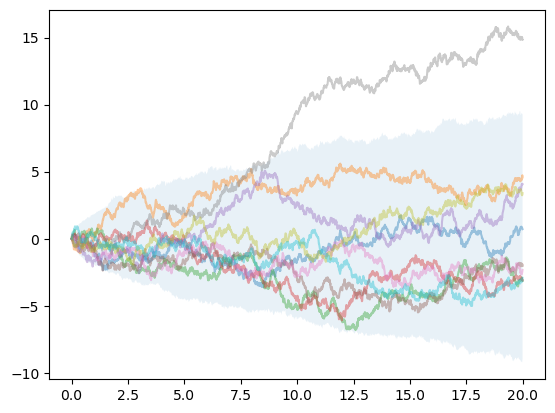

In [3]:
process = StochasticProcess(time=20, dt=0.01, number=500, poisson_rate=6, shape=1, scale=1)
t, Xt = process.brownianmotion()
process.plot_solution(t, Xt, num_max=10, with_quantiles=True)    

We can also generate other processes such as a brownian motion with poisson jumps. This is simply a Brownian Motion plus a Poisson process, for which the jumps are Cauchy distributed. The Cauchy sized jumps heavily affect the paths. This is due to the fact that the tails of the Cauchy distribution are so heavy, that it does not even have an analytical mean.

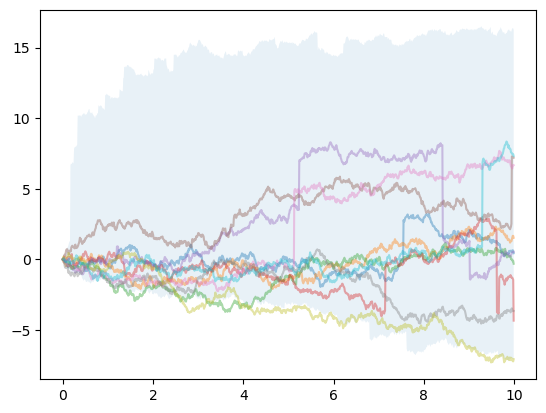

In [6]:
process = StochasticProcess(time=10, dt=0.01, number=100, poisson_rate=7, shape=1, scale=1)
t, Xt = process.levyprocess()
process.plot_solution(t, Xt, with_mean=False, with_var=False, num_max=10)

Stopping times are also part of the class. The code below stops brownian motions at $B_t=\frac12$. However, in general one can also have two different stoppingg points, such as $\tau=inf\{t: B_t=a \cup B_t=b\}$. The expected stopping time is then $E(\tau)=ab$. In the case below, we stop at $\pm \frac12$. The expected stopping time is therefore $\frac14$.

In [16]:
process = StochasticProcess(time=5, dt=0.0001, number=250, poisson_rate=6, shape=1, scale=1)
t, Xt = process.brownianmotion()

mean_stop, var_stop = process.stoppingstatistics(Xt, t, tau=.5) # Mean is about half. Should be 1.
print(mean_stop, var_stop)

0.2590276 0.047407303598240004


Stopping times can be computed numerically for jump processes too.

In [37]:
process = StochasticProcess(time=5, dt=0.001, number=250, poisson_rate=0.5, shape=1, scale=1)
t, Xt = process.levyprocess()
process.stoppingstatistics(Xt, t, tau=0.5)

(0.18152000000000001, 0.0202531776)

An example of numeric stochastic integral. In this example we compute an integral of the form
$$\int_0^t f(s, B_s)dB_s$$
Where $f(t,x)=sin(t)$, note that $x$ is unused at the right hand side. An example is shown below.

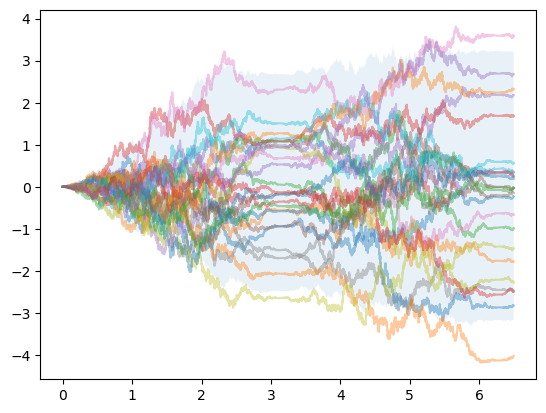

In [8]:
f_function = lambda t, x: np.sin(t)

integrate = StochasticIntegration(time=6.5, dt=0.001, number=100, integrator="brownianmotion")
t, Xt = integrate.stochastic_integral(fun=f_function)
integrate.plot_solution(t, Xt, num_max=25)

Here we choose $f(t,x)=t+x$. This results in the integral $\int_0^t (t+B_t)dB_t$.

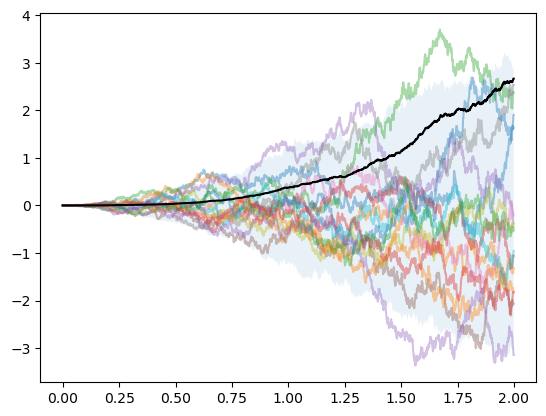

In [20]:
f_function = lambda t, x: t #+ x

integrate = StochasticIntegration(time=2, dt=0.001, number=250, integrator="brownianmotion")
t, Xt = integrate.stochastic_integral(fun=f_function)
integrate.plot_solution(t, Xt, num_max=15, with_var=True)

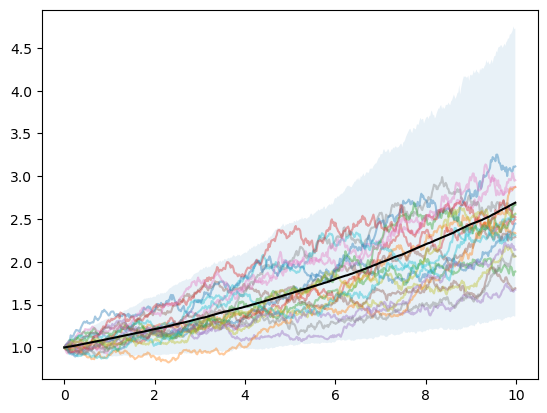

0.41549371452572925 0.3538387844097192


In [7]:
sdesolve = SdeSolver(time=10, dt=0.02, number=1000, poisson_rate=10, shape=.2, scale=2, integrator="brownianmotion")

f = sdesolve.f_blackscholes
g = sdesolve.g_blackscholes

t, Xt = sdesolve.solve_sde(f_func=f, g_func=f, value_init=1, method="Euler Maruyama")
sdesolve.plot_solution(t, Xt, with_mean=True, with_var=False, with_quantiles=True)

returns = sdesolve.european_option(t, Xt, call_time=9, strike_price=2.2)

print(np.mean(returns), np.var(returns))

Aside from the Euler-Maruyama stochastic integration method, there is also a more accurate Milstein version available. An extra (Milstein-)correction is added:
 
$$X_{t+dt}=X_t + f(t,X_t)dt + g(t,X_t)(M_{t+dt}-M_t) + \frac12g(t,X_t)g_x(t,X_t)\left((M_{t+dt}-M_t)^2-dt\right)$$

where $\frac{\partial g}{\partial x}(t,x)=g_x(t,x)$ is the derivative of the stochastic term with respect to the second variable. Especially when the derivative of $g$ with respect to $x% is non-constant, errors can become very large, as seen in the next example:

C:\Users\gouwenss\AppData\Local\Temp\ipykernel_22140\2526956680.py:4: RuntimeWarning: overflow encountered in square
  g = lambda t, x: x**2


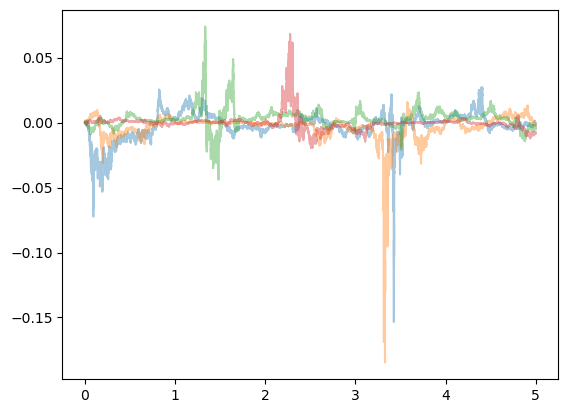

array([[ 0.00000000e+00,  7.50048664e-05,  7.43322538e-05, ...,
         1.91202953e-03,  1.97011070e-03,  2.06675328e-03],
       [ 0.00000000e+00, -4.12672560e-06, -3.83837413e-04, ...,
         2.03951728e-03,  1.77607394e-03,  1.86711392e-03],
       [ 0.00000000e+00, -3.04139276e-05, -1.60708620e-05, ...,
         4.75645843e-03,  4.81353368e-03,  4.92101006e-03],
       ...,
       [ 0.00000000e+00,  9.65021363e-05,  1.96900735e-04, ...,
        -5.51502549e-03, -5.48293956e-03, -5.41773872e-03],
       [ 0.00000000e+00,  2.20058477e-05,  1.12982335e-04, ...,
         9.62700764e-03,  9.68594928e-03,  9.77330944e-03],
       [ 0.00000000e+00,  4.49169205e-05,  1.10590017e-04, ...,
        -2.49306781e-02, -2.52470729e-02, -2.49863178e-02]])

In [32]:
sdesolve = SdeSolver(time=5, dt=0.0001, number=100, poisson_rate=10, shape=.2, scale=2, integrator="brownianmotion")

f = lambda t, x: 1
g = lambda t, x: x**2

np.random.seed(4)
t, Xt_Maruyama = sdesolve.solve_sde(f_func=f, g_func=g, value_init=1, method="Euler Maruyama")
np.random.seed(4)
t, Xt_Milstein = sdesolve.solve_sde(f_func=f, g_func=g, value_init=1, method="Milstein")

# sdesolve.plot_solution(t, Xt_Maruyama, num_max=4, show=False)
sdesolve.plot_solution(t, Xt_Milstein-Xt_Maruyama, num_max=4, show=True)

In [5]:
alpha = 1.1
beta = 0.7
delta = 1
gamma = 0.5
sigma1 = 0.01
sigma2 = 0.01

f_funs = Functionmaker().generate_linears(part_x=[alpha, 0],  part_y=[0, -gamma], part_x_y=[-beta, delta])
g_funs = Functionmaker().generate_linears(part_x=[sigma1, 0], part_y=[0, sigma2])

In the next, we create use Functionmaker to generate the function used in the Lotka Volterra SDE. Note that in normal literature, this is a normal system of differential equations, but a small adjustment turns it into a system of stochastic differential equations. The original is given by:

$$\frac{dx}{dt}=\alpha x(t)- \beta x(t)y(t)$$
$$\frac{dx}{dt}=\delta x(t)y(t)- \gamma y(t)$$

Rewrite into differential form, and add noise that is proportional to the population size yields

$$dX_t = (\alpha X_t - \beta X_tY_t)dt + \sigma_1X_tdB_t$$
$$dY_t = (\delta X_tY_t - \gamma Y_t)dt + \sigma_2Y_tdB_t$$

If $y(t)$ is constant in the upper line, it closely resembles the Black-Scholes equation, but more in an ecological context. In our simulation we choose the values:


$\alpha=X, \beta=X, \delta=X, \gamma=X$

The Funtionmaker.generate_linears method makes a list of functions of the type 
$$f(t, x) = c_0 + c_1t + c_3x + c_4y + c_5xy.$$
This relates to SDE's as they are written in the general form
$$dX_t = f(t, X_t)dt + g(t, X_t)dB_t$$

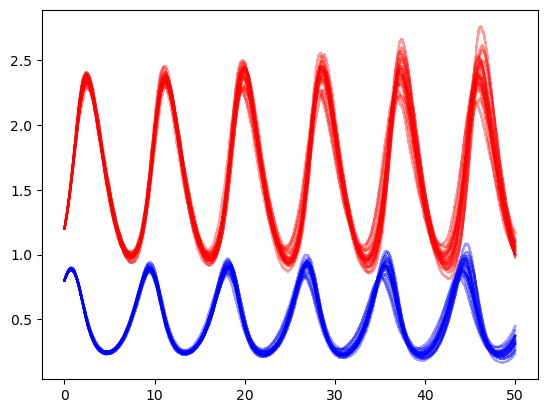

In [11]:
sdesolve = SdeSolver(time=50, dt=0.01, number=25, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")

t, Mt = sdesolve.integrator()
_, M2t = sdesolve.integrator()

dMt = np.hstack((np.diff(Mt), np.zeros((Mt.shape[0], 1)))) 
dM2t = np.hstack((np.diff(Mt), np.zeros((Mt.shape[0], 1)))) 

Xt = np.full_like(Mt, fill_value=.8) 
Yt = np.full_like(Mt, fill_value=1.2) 

for i in range(1, Mt.shape[1]):
    Xt[:,i] = Xt[:,i-1] + f_funs[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*sdesolve.dt + g_funs[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*dMt[:,i]
    Yt[:,i] = Yt[:,i-1] + f_funs[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*sdesolve.dt + g_funs[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*dM2t[:,i]

sdesolve.plot_solution(t, Xt, color="blue", show=False)
sdesolve.plot_solution(t, Yt, color="red")


Similarly to the Lotka-Volterra model we can solve the Heston equation, an equation used for modeling the system of volatility and asset price. This equation is given by

$$dS_t=\mu S_tdt+\sqrt v_tS_tdW_t^{(1)}$$
$$dv_t=\kappa(\theta-v_t)dt+\sigma \sqrt v_tdW_t^{(2)}$$

Where $S_t$ is the asset price and $v_t$ the volatility

In [7]:
f1_Heston = lambda t, x, y: 0.2*x
f2_Heston = lambda t, x, y: np.sqrt(y)*x
g1_Heston = lambda t, x, y: 0.1*(0.7-y)
g2_Heston = lambda t, x, y: 0.01*np.sqrt(y)

f_heston = [f1_Heston, f2_Heston]
g_heston = [g1_Heston, g2_Heston]

Having the functions defined, we can simulate. However, realistic values are not yet chosen.

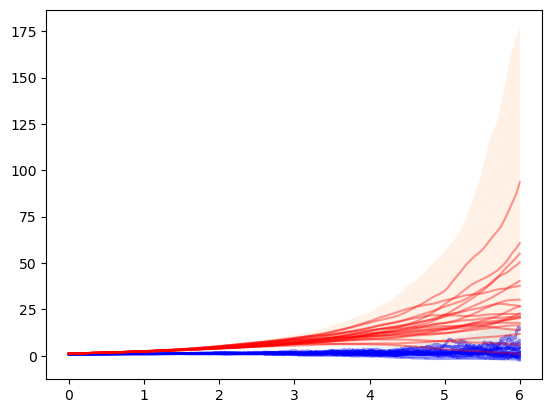

In [10]:
sdesolve = SdeSolver(time=6, dt=0.0001, number=250, poisson_rate=4, shape=1, scale=1, integrator="brownianmotion")

t, Wt1 = sdesolve.integrator()
_, Wt2 = sdesolve.integrator()

dWt1 = np.hstack((np.diff(Wt1), np.zeros((Wt1.shape[0], 1)))) 
dWt2 = np.hstack((np.diff(Wt2), np.zeros((Wt1.shape[0], 1)))) 

Xt = np.full_like(Wt1, fill_value=.8) 
Yt = np.full_like(Wt1, fill_value=1.2) 

for i in range(1, Wt1.shape[1]):
    Xt[:,i] = Xt[:,i-1] + f_heston[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*sdesolve.dt + g_heston[0](t[i-1], Xt[:,i-1], Yt[:,i-1])*dWt1[:,i]
    Yt[:,i] = Yt[:,i-1] + f_heston[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*sdesolve.dt + g_heston[1](t[i-1], Xt[:,i-1], Yt[:,i-1])*dWt2[:,i]

sdesolve.plot_solution(t, Xt, color="blue", show=False)
sdesolve.plot_solution(t, Yt, color="red")


In [2]:
import sympy as sp



sp.Deri

c:\Users\gouwenss\miniconda3\Lib\site-packages\sympy\core\function.py:1233: SymPyDeprecationWarning: 

The string fallback in sympify() is deprecated.

To explicitly convert the string form of an object, use
sympify(str(obj)). To add define sympify behavior on custom
objects, use sympy.core.sympify.converter or define obj._sympy_
(see the sympify() docstring).

sympify() performed the string fallback resulting in the following string:

'<function funct at 0x000001D1E4DD7600>'

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympify-string-fallback
for details.

This has been deprecated since SymPy version 1.6. It
will be removed in a future version of SymPy.

  expr = sympify(expr)


SympifyError: Sympify of expression 'could not parse '<function funct at 0x000001D1E4DD7600>'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)

It may be interesting to generalise the system approach such that any number of equations can be solved. This is not of interest at this point, so we stick with the above.